# **Panorama Stitching**

In [1]:
import gdown
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [2]:
gdown.download_folder(id="1VAB_BG2gntlkwR059zR_8gd9pXajzgIk", quiet=True, use_cookies=False)

['/content/train_images/Set1/1.jpg',
 '/content/train_images/Set1/2.jpg',
 '/content/train_images/Set1/3.jpg',
 '/content/train_images/Set2/1.jpg',
 '/content/train_images/Set2/2.jpg',
 '/content/train_images/Set2/3.jpg',
 '/content/train_images/Set3/1.jpg',
 '/content/train_images/Set3/2.jpg',
 '/content/train_images/Set3/3.jpg',
 '/content/train_images/Set3/4.jpg',
 '/content/train_images/Set3/5.jpg',
 '/content/train_images/Set3/6.jpg',
 '/content/train_images/Set3/7.jpg',
 '/content/train_images/Set3/8.jpg',
 '/content/train_images/.DS_Store']

In [ ]:
gdown.download_folder(id="1U0UxiS3N_25aTd7WxDekug14WDpIXcZX", quiet=True, use_cookies=False)

['/content/test_images/TestSet1/1.jpg',
 '/content/test_images/TestSet1/2.jpg',
 '/content/test_images/TestSet1/3.jpg',
 '/content/test_images/TestSet1/4.jpg',
 '/content/test_images/TestSet2/1.jpg',
 '/content/test_images/TestSet2/2.jpg',
 '/content/test_images/TestSet2/3.jpg',
 '/content/test_images/TestSet2/4.jpg',
 '/content/test_images/TestSet2/5.jpg',
 '/content/test_images/TestSet2/6.jpg',
 '/content/test_images/TestSet2/7.jpg',
 '/content/test_images/TestSet2/8.jpg',
 '/content/test_images/TestSet2/9.jpg',
 '/content/test_images/TestSet3/1.jpg',
 '/content/test_images/TestSet3/2.jpg',
 '/content/test_images/TestSet3/3.jpg']

In [20]:
train_image = mpimg.imread('/content/train_images/Set1/1.jpg')
train_image_2 = mpimg.imread('/content/train_images/Set1/2.jpg')

### Detect Corners and Adaptive Non-Maximal Suppression (ANMS)


#### Corner Detection


In [3]:
def detect_corner(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to gray scale
    gray_img = np.float32(gray_img)

    # strength of corner at each pixel
    cmap = cv2.cornerHarris(gray_img,2,3,0.04)

    # list of detected corners coordinates
    corners = cv2.goodFeaturesToTrack(gray_img, 0, 0.01, 10)
    corners = np.intp(corners)

    return cmap, corners

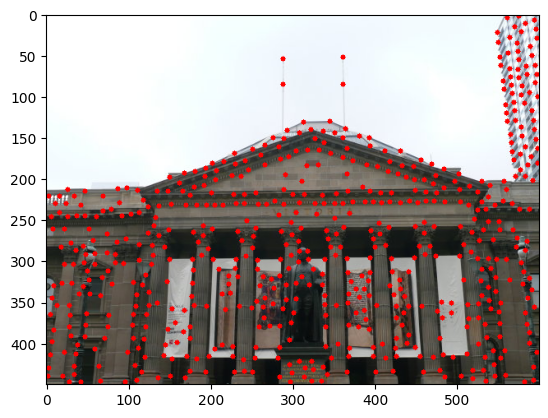

In [5]:
detect_copy = train_image.copy()
cmap, corners = detect_corner(train_image)

for i in corners:
    x, y = i.ravel()
    cv2.circle(detect_copy, (x, y), 3, (255, 0, 0), -1)

plt.imshow(detect_copy)

#### ANMS

Detect corners such that they are equally distributed across the image to avoid weird artifacts in warping.



In [6]:
def ANMS(cmap, corners, num_best):
  N_strong = len(corners)
  r = [np.inf] * N_strong

  # compare all corners
  for i in range(N_strong):
      for j in range(N_strong):
          # check if corner j is stronger than corner i
          x_j, y_j = corners[j][0][1], corners[j][0][0]
          x_i, y_i = corners[i][0][1], corners[i][0][0]
          if cmap[x_j][y_j] > cmap[x_i][y_i]:
              ED = np.linalg.norm(corners[j] - corners[i])
              # update distance
              if ED < r[i]:
                  r[i] = ED

  # get N_best corners with greatest distances
  sorted_indices  = np.argsort(r)[::-1]
  return corners[sorted_indices[:num_best]]

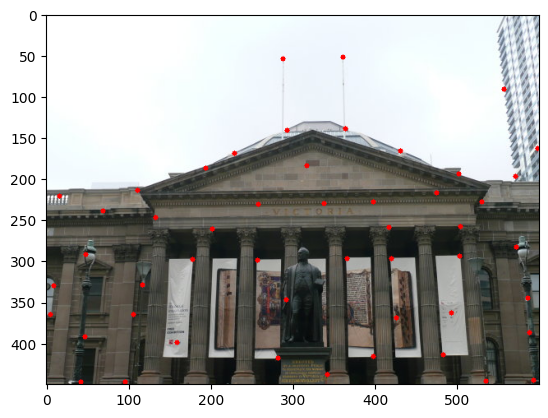

In [7]:
anms_copy = train_image.copy()
N_best_corners = ANMS(cmap, corners, 50)

for i in N_best_corners:
    x, y = i.ravel()
    cv2.circle(anms_copy, (x, y), 3, (255, 0, 0), -1)

plt.imshow(anms_copy)

### Feature Descriptors

Describe each feature point by a feature vector. Take a patches centered around each keypoint and apply gaussian blur. Next, sub-sample the blurred output and reshape to obtain a vector. Standardize the vector to have zero mean and variance of 1. This removes bias and achieves some amount of illumination invariance.

In [13]:
def feature_descript(gray_img, corners):
    feature_descriptors = []
    for corner in corners:
        x, y = corner.ravel()
        # handle features near canvas boundaries
        x_start = max(0, x - 20)
        x_end = min(gray_img.shape[1], x + 20)
        y_start = max(0, y - 20)
        y_end = min(gray_img.shape[0], y + 20)

        patch = gray_img[y_start:y_end, x_start:x_end]

        if patch.size == 0:
          continue

        blurred_patch = cv2.GaussianBlur(patch, (5, 5), sigmaX=1, sigmaY=1)

        # reshape to 64 x 1
        patch = cv2.resize(blurred_patch, (8, 8))
        feature_vector = patch.reshape(-1, 1)

        # normalize for 0 mean and 1 variance
        feature_vector = (feature_vector - np.mean(feature_vector)) / np.std(feature_vector)
        feature_descriptors.append(feature_vector)

    return feature_descriptors

In [14]:
gray_img = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
gray_img = np.float32(gray_img)
feature_descriptors = feature_descript(gray_img, N_best_corners)
assert len(feature_descriptors) == len(N_best_corners)

### Feature Matching

Pick a point in image 1, compute SSD between all points in image 2. Take the ratio of best match (lowest distance) to the second best match (second lowest distance) and if this is below some threshold keep the matched pair or reject it. Repeat this for all points in image 1.



In [24]:
def compute_ssd(vector1,vector2):
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    distances = np.zeros((vector1.shape[0], vector2.shape[0]))

    # pick a point in vector i, compare ssd for all points in vector j
    for i in range(vector1.shape[0]):
      pt_i = vector1[i]
      for j in range(vector2.shape[0]):
        distances[i,j] = np.sum((pt_i - vector2[j])**2)
    return distances

def feature_match(img1, img2, corner1, corner2, threshold=0.75):
    ssd_distances = compute_ssd(corner1, corner2)
    matches = []
    for i in range(ssd_distances.shape[0]):
        distances = ssd_distances[i]

        # lowest dist
        best_match_idx = np.argmin(distances)
        best_match_distance = distances[best_match_idx]
        distances[best_match_idx] = np.inf

        # 2nd lowest dist
        second_best_match_distance = np.min(distances)

        ratio = best_match_distance / second_best_match_distance
        if ratio < threshold:
          matches.append((i, best_match_idx,best_match_distance))

    return matches

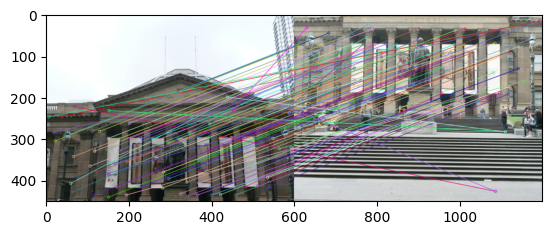

In [25]:
img1 = train_image.copy()
gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray_img1 = np.float32(gray_img1)

img2 = train_image_2.copy()
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gray_img2 = np.float32(gray_img2)

cmap1, corners1 = detect_corner(img1)
cmap2, corners2 = detect_corner(img2)

N_best_corners1 = ANMS(cmap1, corners1, 250)
N_best_corners2 = ANMS(cmap2, corners2, 250)

descriptors1 = feature_descript(gray_img1, N_best_corners1)
descriptors2 = feature_descript(gray_img2, N_best_corners2)

kp1 = [cv2.KeyPoint(x=float(pt[0][0]), y=float(pt[0][1]), size=1) for pt in N_best_corners1]
kp2 = [cv2.KeyPoint(x=float(pt[0][0]), y=float(pt[0][1]), size=1) for pt in N_best_corners2]

matches = feature_match(img1, img2, descriptors1, descriptors2)
good_matches = [cv2.DMatch(_imgIdx=0, _queryIdx=m[0], _trainIdx=m[1], _distance=m[2]) for m in matches]
good_matches = sorted(good_matches, key=lambda x: x.distance)

matched_image = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_image)

### RANSAC to estimate Homography


In [28]:
def compute_ssd(pt1, pt2):
    return np.sum((pt1 - pt2) ** 2)

# randomly select 4 matching points from match_kp1 and match_kp2
def get_random_pts(match_kp1, match_kp2):
    indices = np.random.choice(len(match_kp1), size=4, replace=False)
    pts_src = np.array([match_kp1[i] for i in indices], dtype=np.float32)
    pts_dst = np.array([match_kp2[i] for i in indices], dtype=np.float32)
    return pts_src, pts_dst

# apply homography to src points and count inliers based on SSD threshold
def count_inliers(H, pts_src, pts_dst, threshold):
    count = 0
    inlier_indices = []

    # apply homography to the source points
    transformed_pts = cv2.perspectiveTransform(np.float32(pts_src).reshape(-1, 1, 2), H)

    # check SSD between transformed src points and dst points
    for i in range(len(pts_src)):
        ssd = compute_ssd(transformed_pts[i][0], pts_dst[i])
        if ssd < threshold:
            count += 1
            inlier_indices.append(i)

    return count, inlier_indices

# ransac to compute homography and filter out wrong matches
def RANSAC(match_kp1, match_kp2, N, t, threshold):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(N):
        # select 4 random pairs of matching keypoints
        pts_src, pts_dst = get_random_pts(match_kp1, match_kp2)

        # compute homography between selected points
        H = cv2.getPerspectiveTransform(pts_src, pts_dst)

        if H is None: # skip if no valid homography is found
            continue

        # count how many inliers support the homography
        count, inlier_indices = count_inliers(H, match_kp1, match_kp2, threshold)

        # update best homography if more inliers
        if count > max_inliers:
            max_inliers = count
            best_H = H
            best_inliers = inlier_indices

        if max_inliers > t:
            break

    # compute H hat
    if best_H is not None and len(best_inliers) >= 4:
        inlier_pts_src = np.array([match_kp1[i] for i in best_inliers], dtype=np.float32)
        inlier_pts_dst = np.array([match_kp2[i] for i in best_inliers], dtype=np.float32)

        best_H = cv2.getPerspectiveTransform(inlier_pts_src[:4], inlier_pts_dst[:4])

    return best_H

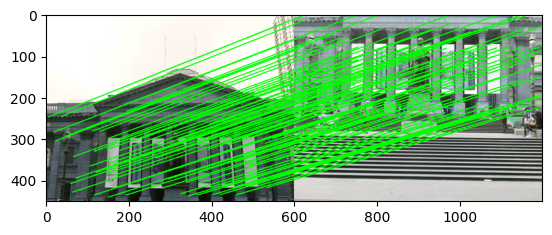

In [29]:
match_kp1 = []
match_kp2 = []

#Filter the corners based on the feature matching
for a,b,c in matches:
  match_kp1.append(N_best_corners1[a])
  match_kp2.append(N_best_corners2[b])

best_homography = RANSAC(match_kp1, match_kp2, N=10000, t=90, threshold=0.5)

match_kp1 = np.array(match_kp1)
match_kp1 = match_kp1.reshape(-1, 2)

ones = np.ones((match_kp1.shape[0], 1))
kp1_mat = np.hstack([match_kp1, ones]).T

# project kp1 onto img2 with homography
projected_points = best_homography @ kp1_mat
projected_points = projected_points[:2, :].T

output_img = np.hstack((img1, img2))

for i in range(len(match_kp1)):
  pt1 = tuple(np.int32(match_kp1[i])) # kp1
  pt2 = tuple(np.int32(projected_points[i] + [img1.shape[1], 0])) # projected kp2

  output_img = cv2.line(output_img, pt1, pt2, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

### Image Warping and Blending

Panorama is created by overlaying the pairwise aligned images. When blending these images, there are inconsistencies due to different exposure/white balance settings, photometric distortions, or vignetting. This is resolved by Poisson blending.

In [30]:
def warp_and_blend(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # corners of img1
    corners_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    warped_corners_img1 = cv2.perspectiveTransform(corners_img1, H)

    # get max bounds using corresponding points after applying homography
    min_x = min(0, warped_corners_img1[:, 0, 0].min())
    min_y = min(0, warped_corners_img1[:, 0, 1].min())
    max_x = max(w2, warped_corners_img1[:, 0, 0].max())
    max_y = max(h2, warped_corners_img1[:, 0, 1].max())

    # size of expanded canvas
    canvas_width = int(max_x - min_x)
    canvas_height = int(max_y - min_y)

    # translate homography to account for shifting the images
    translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    H_translated = translation_matrix @ H

    # warp img1 onto the new expanded canvas
    warped_img1 = cv2.warpPerspective(img1, H_translated, (canvas_width, canvas_height))

    # adjust canvas for img2
    expanded_img2 = np.zeros((canvas_height, canvas_width, 3), dtype=img2.dtype)
    expanded_img2[-int(min_y):h2-int(min_y), -int(min_x):w2-int(min_x)] = img2

    # binary blending the images
    mask1 = cv2.cvtColor(warped_img1, cv2.COLOR_BGR2GRAY)
    mask1[mask1 > 0] = 1
    mask2 = 1 - mask1

    # fill negative space in warped_img1 with corresponding pixels from expanded_img2
    filled_warped_img1 = warped_img1.copy()
    filled_warped_img1[mask1 == 0] = expanded_img2[mask1 == 0]

    # blend the two images
    alpha = 0.5
    blended_img = cv2.addWeighted(filled_warped_img1, alpha, expanded_img2, 1 - alpha, 0)

    return blended_img

### Stitching Multiple Images

In [39]:
# compute H between consecutive image pairs
def pano_imgs(img_list):
    # start with the first image
    panorama = img_list[0]
    H = None

    # iterate through each consecutive pair of images
    for i in range(1, len(img_list)):
      img1 = panorama.copy() # the current stitched image
      img2 = img_list[i].copy() # the next image to be stitched

      gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
      gray_img1 = np.float32(gray_img1)

      gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
      gray_img2 = np.float32(gray_img2)

      cmap1, corners1 = detect_corner(img1)
      cmap2, corners2 = detect_corner(img2)

      N_best_corners1 = ANMS(cmap1, corners1, 250)
      N_best_corners2 = ANMS(cmap2, corners2, 250)

      # extract keypoints and descriptors from img1 and img2
      descriptors1 = feature_descript(gray_img1, N_best_corners1)
      descriptors2 = feature_descript(gray_img2, N_best_corners2)

      # find feature matches between img1 and img2
      matches = feature_match(img1, img2, descriptors1, descriptors2)

      # extract matching keypoints
      match_kp1 = []
      match_kp2 = []
      # filter the corners based on the feature matching
      for a,b,c in matches:
        match_kp1.append(N_best_corners1[a])
        match_kp2.append(N_best_corners2[b])

      # use RANSAC to find the best homography matrix
      H = RANSAC(match_kp1, match_kp2, N=1000, t=90, threshold=0.5)

      if H is None:
          print(f"Homography not found for image pair {i-1} and {i}")
          continue

      # warp and blend the current panorama with the next image
      panorama = warp_and_blend(img1, img2, H)

    return panorama

In [40]:
# def compute_ssd(pt1, pt2):
#     return np.sum((pt1 - pt2) ** 2)

def compute_ssd(vector1, vector2):
    # Convert inputs to NumPy arrays before performing operations
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)

    # Proceed with the original calculation
    distances = np.zeros((vector1.shape[0], vector2.shape[0]))
    for i in range(vector1.shape[0]):
        pt_i = vector1[i]
        for j in range(vector2.shape[0]):
            distances[i, j] = np.sum((pt_i - vector2[j]) ** 2)
    return distances

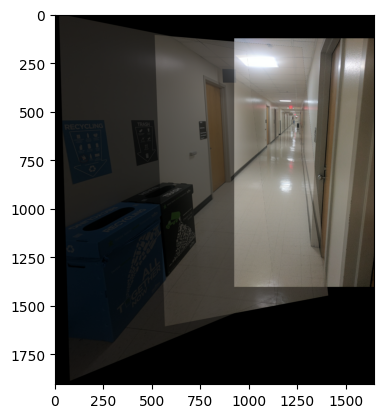

In [ ]:
img1 = mpimg.imread('/content/test_images/TestSet3/1.jpg')
img2 = mpimg.imread('/content/test_images/TestSet3/2.jpg')
img3 = mpimg.imread('/content/test_images/TestSet3/3.jpg')

plt.imshow(pano_imgs([img1,img2,img3]))